This notebook discusses the neural network approach.

The best performed neural network has two hidden layers of size (30, 30), trained with epochs=10, batch_size=100, which has validation accuracy 0.74. 

PCA does not improve the performance, maybe pca losses some information of the data.

In [2]:
# Import packages
import re
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load the data
file_train = open("data/train.json", "r")
file_test = open("data/test.json", "r")
data_train = json.load(file_train)
data_test = json.load(file_test)

In [4]:
# make labels for training set
y_train = [recipe['cuisine'] for recipe in data_train]
y_train = pd.DataFrame(y_train, columns=['cuisine'])
y_train.head()

,cuisine
0,greek
1,southern_us
2,filipino
3,indian
4,indian


In [5]:
# Transform the labels into numerical values
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train.cuisine.astype(str))
y_train['cusine_code'] = label_encoder.transform(y_train.cuisine.astype(str)).astype(int)



In [5]:
y_train.head()

,cuisine,cusine_code
0,greek,6
1,southern_us,16
2,filipino,4
3,indian,7
4,indian,7


In [6]:
# train test split with random_state=330, this will be used later 
data_tt, data_val, y_tt, y_val = train_test_split(data_train,y_train,
                                                  test_size = .2,
                                                 shuffle=True,
                                                  random_state=330,
                                                 stratify=y_train['cusine_code'])

In [21]:
# Select the special ingredients fron data_tt
# exclude those from X_val
Sets = dict()
Special = dict()

for cuisine in set(y_tt.cuisine):
    Sets[cuisine] = set()

for recipe in data_tt:
    Sets[recipe['cuisine']] = Sets[recipe['cuisine']].union(set(recipe['ingredients']))

for cuisine in set(y_tt.cuisine):
    Special[cuisine] = Sets[cuisine]
    for j in set(y_tt.cuisine) - {cuisine}:
        Special[cuisine] = Special[cuisine] - Sets[j] 
Special_ingredients = set()
for ingredients in Special.values():
    Special_ingredients = Special_ingredients.union(ingredients)

In [8]:
# load the word to vec model
import gensim.downloader as api
w2v_model = api.load("glove-wiki-gigaword-300")

In [9]:
# Creating the embedding vectors for data_train

embedding_dim = len(w2v_model.get_vector('hello'))
Data = np.zeros((len(data_train), embedding_dim))

for row in range(len(data_train)):
    ingredients = data_train[row]['ingredients']
    ingred_list = []
    for ingred in ingredients:
        ingred = ingred.lower()
        res = re.split('[^a-zA-Z0-9]+', ingred) 
        ingred_list.extend(res)
    
    Data[row] = w2v_model.get_mean_vector(ingred_list)
X_train = pd.DataFrame(Data)

In [10]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.007129,0.014538,0.037972,-0.002912,-0.019502,-0.035497,-0.035003,0.012690,0.009769,0.006574,...,-0.000511,0.002482,0.029561,-0.008820,-0.055830,-0.068829,-0.007445,-0.033466,0.033222,0.022508
1,-0.010825,0.037093,0.025090,-0.022936,-0.024930,-0.034393,-0.012253,0.026217,0.017413,-0.093013,...,-0.003094,0.003128,0.006862,0.020216,-0.008999,-0.022631,0.004138,-0.051838,0.006054,0.024809
2,-0.001878,0.025028,0.028985,-0.030870,-0.020794,-0.041656,-0.013798,0.023472,0.016664,-0.050984,...,-0.028241,0.010351,0.024706,-0.004655,-0.032478,-0.072424,0.007893,-0.048366,0.008881,0.026711
3,0.005193,0.016592,-0.005436,-0.032777,-0.012471,0.013311,-0.006194,0.015425,0.030766,-0.142578,...,-0.048216,-0.000493,0.015772,0.021818,0.045742,0.007719,0.003154,-0.094063,-0.018717,0.046306
4,-0.001775,0.033189,0.017418,-0.017050,-0.029041,-0.037277,-0.016641,0.008630,0.013647,-0.038315,...,-0.026515,0.010357,0.014744,-0.006545,-0.013195,-0.045015,0.010750,-0.030593,0.006772,0.042275


In [11]:
X_train.shape

(39774, 300)

In [12]:
# we use the same train_test_split with random_state=330
X_tt, X_val, y_tt, y_val = train_test_split(X_train, y_train, 
                                           test_size=0.2,
                                            shuffle=True,
                                           random_state=330,
                                           stratify=y_train['cusine_code'])

In [13]:
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import metrics
from keras.utils.np_utils import to_categorical

In [14]:
# neural network with 2 hidden layers of size (30, 30)
nw = models.Sequential()

nw.add(layers.Dense(30, activation='relu', input_shape=(X_tt.shape[1],)))
nw.add(layers.Dense(30, activation='relu'))
nw.add(layers.Dense(20, activation='softmax'))

nw.compile(loss='categorical_crossentropy', optimizer= 'Adam', metrics= 'accuracy')

Metal device set to: Apple M1


2022-06-03 14:58:52.245473: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-03 14:58:52.247540: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
# Standardize the data into normal distribution
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(n_quantiles=1000, 
                         output_distribution='normal',
                         random_state=330)
qt.fit(X_tt)
X_tt_norm = qt.transform(X_tt)
X_val_norm = qt.transform(X_val)

In [45]:
nw_history = nw.fit(X_tt_norm, to_categorical(y_tt['cusine_code']),
      epochs = 30,
      batch_size=100,
      validation_data=(X_val_norm, to_categorical(y_val['cusine_code'])))

Epoch 1/30
319/319 [==============================] - 4s 13ms/step - loss: 0.6418 - accuracy: 0.8027 - val_loss: 0.9039 - val_accuracy: 0.7422
Epoch 2/30
319/319 [==============================] - 4s 14ms/step - loss: 0.6368 - accuracy: 0.8027 - val_loss: 0.9060 - val_accuracy: 0.7429
Epoch 3/30
319/319 [==============================] - 3s 10ms/step - loss: 0.6363 - accuracy: 0.8010 - val_loss: 0.9127 - val_accuracy: 0.7400
Epoch 4/30
319/319 [==============================] - 3s 9ms/step - loss: 0.6325 - accuracy: 0.8019 - val_loss: 0.9108 - val_accuracy: 0.7412
Epoch 5/30
319/319 [==============================] - 5s 16ms/step - loss: 0.6289 - accuracy: 0.8031 - val_loss: 0.9142 - val_accuracy: 0.7409
Epoch 6/30
319/319 [==============================] - 4s 12ms/step - loss: 0.6269 - accuracy: 0.8041 - val_loss: 0.9098 - val_accuracy: 0.7436
Epoch 7/30
319/319 [==============================] - 4s 11ms/step - loss: 0.6251 - accuracy: 0.8061 - val_loss: 0.9070 - val_accuracy: 0.7394


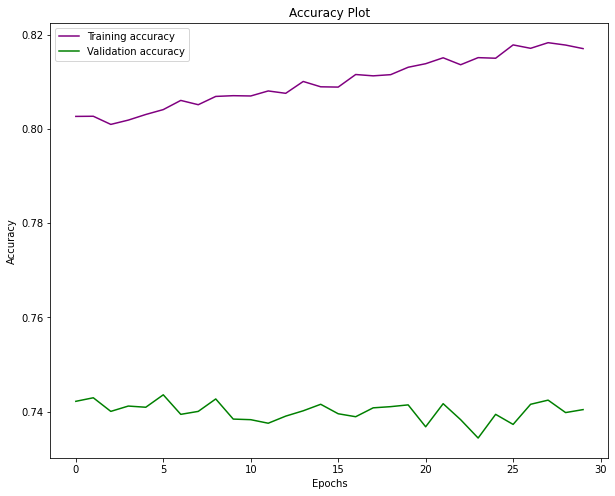

In [46]:
plt.figure(figsize = (10,8))
plt.plot(nw_history.history['accuracy'], label = 'Training accuracy', color = 'purple')
plt.plot(nw_history.history['val_accuracy'], label = 'Validation accuracy', color = 'green')
plt.title('Accuracy Plot')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [17]:
# same neural network with epochs=20 and batch_size=10
nw2 = models.Sequential()

nw2.add(layers.Dense(30, activation='relu', input_shape=(X_tt.shape[1],)))
nw2.add(layers.Dense(30, activation='relu'))
nw2.add(layers.Dense(20, activation='softmax'))

nw2.compile(loss='categorical_crossentropy', optimizer= 'Adam', metrics= 'accuracy')

In [18]:
nw2_history = nw2.fit(X_tt_norm, to_categorical(y_tt['cusine_code']),
      epochs = 20,
      batch_size=10,
      validation_data=(X_val_norm, to_categorical(y_val['cusine_code'])))

Epoch 1/20


2022-06-03 15:02:34.077722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3182/3182 [==============================] - ETA: 0s - loss: 1.2365 - accuracy: 0.6388

2022-06-03 15:02:55.727513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3182/3182 [==============================] - 25s 8ms/step - loss: 1.2365 - accuracy: 0.6388 - val_loss: 1.0121 - val_accuracy: 0.6992
Epoch 2/20
3182/3182 [==============================] - 24s 7ms/step - loss: 0.9464 - accuracy: 0.7149 - val_loss: 0.9506 - val_accuracy: 0.7141
Epoch 3/20
3182/3182 [==============================] - 25s 8ms/step - loss: 0.8779 - accuracy: 0.7366 - val_loss: 0.9382 - val_accuracy: 0.7218
Epoch 4/20
3182/3182 [==============================] - 24s 7ms/step - loss: 0.8398 - accuracy: 0.7475 - val_loss: 0.9136 - val_accuracy: 0.7338
Epoch 5/20
3182/3182 [==============================] - 26s 8ms/step - loss: 0.8130 - accuracy: 0.7537 - val_loss: 0.9085 - val_accuracy: 0.7392
Epoch 6/20
3182/3182 [==============================] - 28s 9ms/step - loss: 0.7927 - accuracy: 0.7606 - val_loss: 0.9211 - val_accuracy: 0.7290
Epoch 7/20
3182/3182 [==============================] - 24s 8ms/step - loss: 0.7731 - accuracy: 0.7659 - val_loss: 0.9222 - val_accuracy: 0.7

Text(0, 0.5, 'Accuracy')

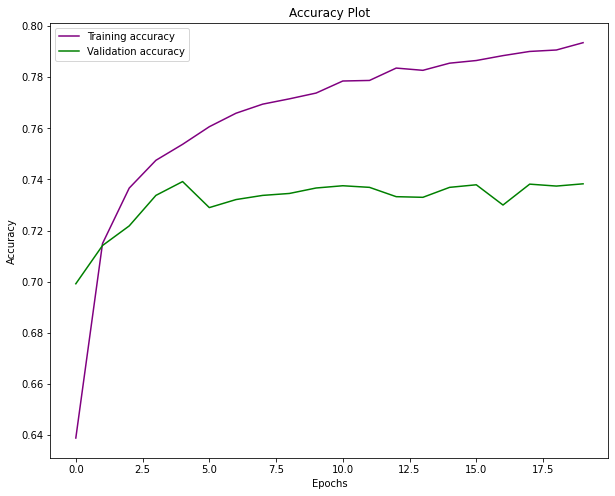

In [20]:
plt.figure(figsize = (10,8))
plt.plot(nw2_history.history['accuracy'], label = 'Training accuracy', color = 'purple')
plt.plot(nw2_history.history['val_accuracy'], label = 'Validation accuracy', color = 'green')
plt.title('Accuracy Plot')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [35]:
# third neural network with three hidden layers of size (30,20,30)

nw3 = models.Sequential()

nw3.add(layers.Dense(30, activation='relu', input_shape=(X_tt.shape[1],)))
nw3.add(layers.Dense(20, activation='relu'))
nw3.add(layers.Dense(30, activation='relu'))
nw3.add(layers.Dense(20, activation='softmax'))

nw3.compile(loss='categorical_crossentropy', optimizer= 'Adam', metrics= 'accuracy')

In [37]:
nw3_history = nw3.fit(X_tt_norm, to_categorical(y_tt['cusine_code']),
      epochs =30,
      batch_size=100,
      validation_data=(X_val_norm, to_categorical(y_val['cusine_code'])))

Epoch 1/15
  16/3182 [..............................] - ETA: 21s - loss: 3.0934 - accuracy: 0.0500     

2022-06-03 13:39:51.478562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3179/3182 [============================>.] - ETA: 0s - loss: 1.2988 - accuracy: 0.6166

2022-06-03 13:40:12.745138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3182/3182 [==============================] - 25s 8ms/step - loss: 1.2988 - accuracy: 0.6167 - val_loss: 1.0846 - val_accuracy: 0.6720
Epoch 2/15
3182/3182 [==============================] - 24s 8ms/step - loss: 0.9982 - accuracy: 0.6992 - val_loss: 0.9837 - val_accuracy: 0.7086
Epoch 3/15
3182/3182 [==============================] - 23s 7ms/step - loss: 0.9219 - accuracy: 0.7196 - val_loss: 0.9626 - val_accuracy: 0.7145
Epoch 4/15
3182/3182 [==============================] - 23s 7ms/step - loss: 0.8797 - accuracy: 0.7343 - val_loss: 0.9429 - val_accuracy: 0.7253
Epoch 5/15
3182/3182 [==============================] - 24s 8ms/step - loss: 0.8510 - accuracy: 0.7416 - val_loss: 0.9425 - val_accuracy: 0.7183
Epoch 6/15
3182/3182 [==============================] - 26s 8ms/step - loss: 0.8269 - accuracy: 0.7498 - val_loss: 0.9622 - val_accuracy: 0.7144
Epoch 7/15
3182/3182 [==============================] - 31s 10ms/step - loss: 0.8072 - accuracy: 0.7555 - val_loss: 0.9483 - val_accuracy: 0.

Text(0, 0.5, 'Accuracy')

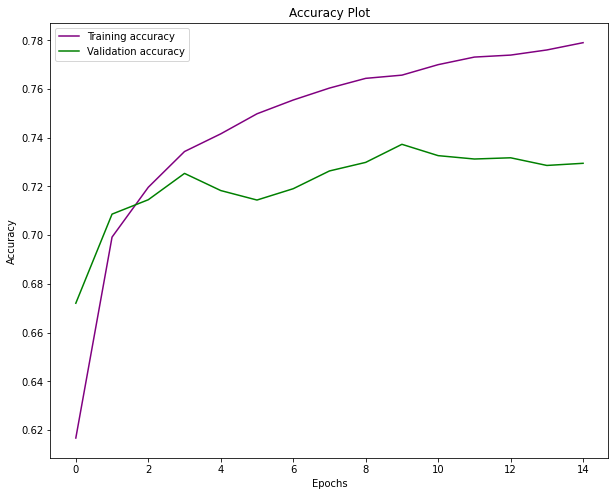

In [39]:
plt.figure(figsize = (10,8))
plt.plot(nw3_history.history['accuracy'], label = 'Training accuracy', color = 'purple')
plt.plot(nw3_history.history['val_accuracy'], label = 'Validation accuracy', color = 'green')
plt.title('Accuracy Plot')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [51]:
nw5 = models.Sequential()

nw5.add(layers.Dense(30, activation='relu', input_shape=(X_tt.shape[1],)))
nw5.add(layers.Dense(30, activation='relu'))
#nw5.add(layers.Dense(20, activation='relu'))
nw5.add(layers.Dense(20, activation='softmax'))

nw5.compile(loss='categorical_crossentropy', optimizer= 'Adam', metrics= 'accuracy')

In [52]:
nw5_history = nw5.fit(X_tt_norm, to_categorical(y_tt['cusine_code']),
      epochs = 30,
      batch_size=100,
      validation_data=(X_val_norm, to_categorical(y_val['cusine_code'])))

Epoch 1/30
 16/319 [>.............................] - ETA: 2s - loss: 2.8553 - accuracy: 0.1619

2022-06-03 13:56:15.437410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


319/319 [==============================] - ETA: 0s - loss: 1.5584 - accuracy: 0.5587

2022-06-03 13:56:17.659891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


319/319 [==============================] - 3s 8ms/step - loss: 1.5584 - accuracy: 0.5587 - val_loss: 1.1576 - val_accuracy: 0.6554
Epoch 2/30
319/319 [==============================] - 2s 8ms/step - loss: 1.0704 - accuracy: 0.6813 - val_loss: 1.0250 - val_accuracy: 0.6943
Epoch 3/30
319/319 [==============================] - 3s 10ms/step - loss: 0.9602 - accuracy: 0.7121 - val_loss: 0.9727 - val_accuracy: 0.7115
Epoch 4/30
319/319 [==============================] - 3s 9ms/step - loss: 0.8998 - accuracy: 0.7297 - val_loss: 0.9424 - val_accuracy: 0.7163
Epoch 5/30
319/319 [==============================] - 3s 9ms/step - loss: 0.8581 - accuracy: 0.7403 - val_loss: 0.9262 - val_accuracy: 0.7238
Epoch 6/30
319/319 [==============================] - 3s 9ms/step - loss: 0.8289 - accuracy: 0.7500 - val_loss: 0.9125 - val_accuracy: 0.7278
Epoch 7/30
319/319 [==============================] - 3s 9ms/step - loss: 0.8047 - accuracy: 0.7568 - val_loss: 0.9079 - val_accuracy: 0.7340
Epoch 8/30
319/3

Text(0, 0.5, 'Accuracy')

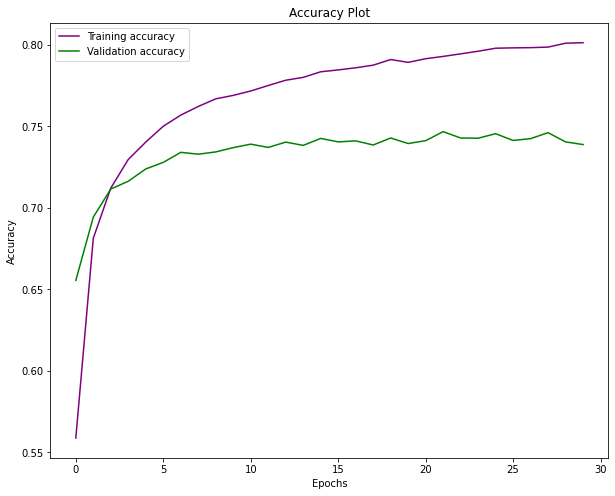

In [53]:
plt.figure(figsize = (10,8))
plt.plot(nw5_history.history['accuracy'], label = 'Training accuracy', color = 'purple')
plt.plot(nw5_history.history['val_accuracy'], label = 'Validation accuracy', color = 'green')
plt.title('Accuracy Plot')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

It looks like the model `nw` with two hidden layers of size (30,30) has best performance, we train this model with 10 epochs and compute the validation accuracy.

In [47]:
nw = models.Sequential()

nw.add(layers.Dense(30, activation='relu', input_shape=(X_tt.shape[1],)))
nw.add(layers.Dense(30, activation='relu'))
nw.add(layers.Dense(20, activation='softmax'))

nw.compile(loss='categorical_crossentropy', optimizer= 'Adam', metrics= 'accuracy')

In [48]:
nw_history = nw.fit(X_tt_norm, to_categorical(y_tt['cusine_code']),
      epochs = 10,
      batch_size=100,
      validation_data=(X_val_norm, to_categorical(y_val['cusine_code'])))

Epoch 1/10
 14/319 [>.............................] - ETA: 2s - loss: 2.8576 - accuracy: 0.1607

2022-06-03 15:39:39.298377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


317/319 [============================>.] - ETA: 0s - loss: 1.5593 - accuracy: 0.5579

2022-06-03 15:39:41.819595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


319/319 [==============================] - 3s 9ms/step - loss: 1.5581 - accuracy: 0.5583 - val_loss: 1.1620 - val_accuracy: 0.6527
Epoch 2/10
319/319 [==============================] - 2s 8ms/step - loss: 1.0719 - accuracy: 0.6818 - val_loss: 1.0228 - val_accuracy: 0.6915
Epoch 3/10
319/319 [==============================] - 2s 7ms/step - loss: 0.9581 - accuracy: 0.7128 - val_loss: 0.9613 - val_accuracy: 0.7125
Epoch 4/10
319/319 [==============================] - 3s 8ms/step - loss: 0.8958 - accuracy: 0.7308 - val_loss: 0.9367 - val_accuracy: 0.7224
Epoch 5/10
319/319 [==============================] - 3s 8ms/step - loss: 0.8571 - accuracy: 0.7426 - val_loss: 0.9260 - val_accuracy: 0.7224
Epoch 6/10
319/319 [==============================] - 2s 7ms/step - loss: 0.8299 - accuracy: 0.7497 - val_loss: 0.9112 - val_accuracy: 0.7329
Epoch 7/10
319/319 [==============================] - 2s 8ms/step - loss: 0.8054 - accuracy: 0.7571 - val_loss: 0.8994 - val_accuracy: 0.7332
Epoch 8/10
319/31

In [49]:
# Validation accuracy without joining special ingredients filter

num = 0
for i in range(len(data_val)):
    test_vec = np.array(X_val_norm[i]).reshape(-1,X_val_norm.shape[1])
    pred = np.argmax(nw.predict(test_vec))
    
    if pred == y_val.iloc[i]['cusine_code']:
        num = num + 1
print(num / len(data_val))

2022-06-03 15:40:13.469304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0.7400377121307354


In [50]:
# Test the validation accuracy if incorporate with the Special ingresient filter
# the special ingredients only come from X_tt

Incorrect = 0
Correct = 0

for i in range(len(data_val)):
    if any(ele in Special_ingredients for ele in data_val[i]['ingredients']):
        for cuisine in Special.keys():
            if any(ele in Special[cuisine] for ele in data_val[i]['ingredients']):
                if cuisine == data_val[i]['cuisine']:
                    Correct+= 1
                else:
                    Incorrect+= 1
                break
    else:
        test_vec = np.array(X_val_norm[i]).reshape(-1,X_val_norm.shape[1])
        pred = np.argmax(nw.predict(test_vec))
        if pred == y_val.iloc[i]['cusine_code']:
            Correct+= 1
        else:
            Incorrect+=1

print(Correct/(len(data_val)))

0.7311125078566939


It looks like the special ingredients filter does not help much.

#### Now we apply PCA on the data before training model

In [27]:
# PCA
pca = PCA(0.99)
pca.fit(X_train.values)

X_train_pca = pca.transform(X_train.values)
X_train_pca.shape

(39774, 196)

In [28]:
# same train test split after pca
X_tt_pca, X_val_pca, y_tt, y_val = train_test_split(X_train_pca, y_train, 
                                           test_size=0.2,
                                            shuffle=True,
                                           random_state=330,
                                           stratify=y_train['cusine_code'])

In [34]:
# neural network after pca with two hidden layers of size (30, 30)
nw_pca = models.Sequential()

nw_pca.add(layers.Dense(30, activation='relu', input_shape=(X_tt_pca.shape[1],)))
nw_pca.add(layers.Dense(30, activation='relu'))
nw_pca.add(layers.Dense(20, activation='softmax'))

nw_pca.compile(loss='categorical_crossentropy', optimizer= 'Adam', metrics= 'accuracy')

In [35]:
# Standardize the data into normal distribution
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(n_quantiles=1000, 
                         output_distribution='normal',
                         random_state=330)
qt.fit(X_tt_pca)
X_tt_pca_norm = qt.transform(X_tt_pca)
X_val_pca_norm = qt.transform(X_val_pca)

In [36]:
nw_pca.fit(X_tt_pca_norm, to_categorical(y_tt['cusine_code']),
      epochs = 30,
      batch_size=100,
      validation_data=(X_val_pca_norm, to_categorical(y_val['cusine_code'])))

Epoch 1/30
 15/319 [>.............................] - ETA: 2s - loss: 3.1231 - accuracy: 0.0760

2022-06-03 15:20:18.499715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


319/319 [==============================] - ETA: 0s - loss: 2.0949 - accuracy: 0.4176

2022-06-03 15:20:22.121878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


319/319 [==============================] - 4s 12ms/step - loss: 2.0949 - accuracy: 0.4176 - val_loss: 1.4566 - val_accuracy: 0.6019
Epoch 2/30
319/319 [==============================] - 3s 8ms/step - loss: 1.2127 - accuracy: 0.6555 - val_loss: 1.1064 - val_accuracy: 0.6759
Epoch 3/30
319/319 [==============================] - 2s 7ms/step - loss: 0.9912 - accuracy: 0.7064 - val_loss: 1.0112 - val_accuracy: 0.7066
Epoch 4/30
319/319 [==============================] - 2s 8ms/step - loss: 0.9051 - accuracy: 0.7300 - val_loss: 0.9738 - val_accuracy: 0.7175
Epoch 5/30
319/319 [==============================] - 3s 9ms/step - loss: 0.8566 - accuracy: 0.7442 - val_loss: 0.9560 - val_accuracy: 0.7234
Epoch 6/30
319/319 [==============================] - 3s 9ms/step - loss: 0.8251 - accuracy: 0.7528 - val_loss: 0.9414 - val_accuracy: 0.7281
Epoch 7/30
319/319 [==============================] - 3s 9ms/step - loss: 0.8014 - accuracy: 0.7591 - val_loss: 0.9372 - val_accuracy: 0.7307
Epoch 8/30
319/3

In [42]:
# It looks like 10 epochs is already good, so we train the model with 10 epochs

nw_pca = models.Sequential()

nw_pca.add(layers.Dense(30, activation='relu', input_shape=(X_tt_pca.shape[1],)))
nw_pca.add(layers.Dense(30, activation='relu'))
nw_pca.add(layers.Dense(20, activation='softmax'))

nw_pca.compile(loss='categorical_crossentropy', optimizer= 'Adam', metrics= 'accuracy')

nw_pca.fit(X_tt_pca_norm, to_categorical(y_tt['cusine_code']),
      epochs = 10,
      batch_size=100,
      validation_data=(X_val_pca_norm, to_categorical(y_val['cusine_code'])))

Epoch 1/10
  8/319 [..............................] - ETA: 2s - loss: 3.1470 - accuracy: 0.0763  

2022-06-03 15:29:28.621185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


317/319 [============================>.] - ETA: 0s - loss: 2.0996 - accuracy: 0.4164

2022-06-03 15:29:30.787051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


319/319 [==============================] - 3s 8ms/step - loss: 2.0978 - accuracy: 0.4170 - val_loss: 1.4600 - val_accuracy: 0.5995
Epoch 2/10
319/319 [==============================] - 3s 8ms/step - loss: 1.2159 - accuracy: 0.6551 - val_loss: 1.1148 - val_accuracy: 0.6778
Epoch 3/10
319/319 [==============================] - 2s 7ms/step - loss: 0.9913 - accuracy: 0.7068 - val_loss: 1.0169 - val_accuracy: 0.7055
Epoch 4/10
319/319 [==============================] - 2s 7ms/step - loss: 0.9044 - accuracy: 0.7305 - val_loss: 0.9766 - val_accuracy: 0.7179
Epoch 5/10
319/319 [==============================] - 2s 8ms/step - loss: 0.8563 - accuracy: 0.7424 - val_loss: 0.9566 - val_accuracy: 0.7234
Epoch 6/10
319/319 [==============================] - 3s 9ms/step - loss: 0.8247 - accuracy: 0.7522 - val_loss: 0.9494 - val_accuracy: 0.7242
Epoch 7/10
319/319 [==============================] - 2s 8ms/step - loss: 0.7999 - accuracy: 0.7572 - val_loss: 0.9408 - val_accuracy: 0.7278
Epoch 8/10
319/31

In [43]:
# Validation accuracy without joining special ingredients filter

num = 0
for i in range(len(data_val)):
    test_vec = np.array(X_val_pca_norm[i]).reshape(-1,X_val_pca_norm.shape[1])
    pred = np.argmax(nw_pca.predict(test_vec))
    
    if pred == y_val.iloc[i]['cusine_code']:
        num = num + 1
print("the validation accuracy is: ", num / len(data_val))

2022-06-03 15:29:56.181570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


the validation accuracy is:  0.7332495285983658


In [44]:
# Test the validation accuracy if incorporate with the Special ingresient filter
# the special ingredients only come from X_tt

Incorrect = 0
Correct = 0

for i in range(len(data_val)):
    if any(ele in Special_ingredients for ele in data_val[i]['ingredients']):
        for cuisine in Special.keys():
            if any(ele in Special[cuisine] for ele in data_val[i]['ingredients']):
                if cuisine == data_val[i]['cuisine']:
                    Correct+= 1
                else:
                    Incorrect+= 1
                break
    else:
        test_vec = np.array(X_val_pca_norm[i]).reshape(-1,X_val_pca_norm.shape[1])
        pred = np.argmax(nw_pca.predict(test_vec))
        if pred == y_val.iloc[i]['cusine_code']:
            Correct+= 1
        else:
            Incorrect+=1

print("The validation accuracy with special ingredients filter is: ", Correct/(len(data_val)))

The validation accuracy with special ingredients filter is:  0.7244500314267757
